In [2]:
import json
import numpy as np 
from collections import defaultdict 

In [3]:
def read_file(path):
    data_by_src = defaultdict(list)
    with open(path, "r") as f1:
        for line in f1:
            line = json.loads(line)
            # trim off last token (EOS)
            line['logit_at_label'] = np.array(line['logit_at_label'][0:-1])
            data_by_src[line['natural']].append(line)

    # for src, list_ in data_by_src.items():
        # assert(len(list_) == 2)

    return data_by_src


In [15]:
from utils import detect_amb_type

data_for_df = []

for model in ["codegen-350M", "codegen-2B", "codegen-6B", "codegen-16B"]:
    for s1 in range(0, 110, 10):
        s2 = 100 - s1
        path = f"/brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/{model}/{s1}-{s2}-5k-train-100-perc-ambig_fol_fewshot/outputs/test_eval.logits"
        print(f"reading {path}")
        try:
            data_by_src = read_file(path)
        except FileNotFoundError:
            print(f"file not found: {path}")
            continue

        mins_by_lf = defaultdict(list)
        for src, lines in data_by_src.items():
            p_lf0, p_lf1 = None, None
            min_lf0, min_lf1 = None, None
            for line in lines:
                template_idx = str(line['template_idx'])
                total_prob = np.exp(np.sum(np.log(line['logit_at_label'])))

                min_logit_at_label = np.min(line['logit_at_label']) 
                if template_idx == '0':
                    min_lf0 = min_logit_at_label
                    p_lf0 = total_prob
                else:
                    min_lf1 = min_logit_at_label
                    p_lf1 = total_prob

            # turn into a proper probability by normalizing 
            norm_min_p_lf0 = min_lf0 / (min_lf0 + min_lf1)
            norm_total_p_lf0 = p_lf0 / (p_lf0 + p_lf1)
            amb_type = detect_amb_type(lines[0]['natural'])


            data_for_df.append({"model": model, "s1": s1/100, "s2": s2/100, "type": "norm_min_lf0", "value": norm_min_p_lf0, "amb_type": amb_type}) 
            data_for_df.append({"model": model, "s1": s1/100, "s2": s2/100, "type": "norm_total_lf0", "value": norm_total_p_lf0, "amb_type": amb_type}) 



reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/0-100-5k-train-100-perc-ambig_fol_fewshot/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/10-90-5k-train-100-perc-ambig_fol_fewshot/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/20-80-5k-train-100-perc-ambig_fol_fewshot/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/30-70-5k-train-100-perc-ambig_fol_fewshot/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/40-60-5k-train-100-perc-ambig_fol_fewshot/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/50-50-5k-train-100-perc-ambig_fol_fewshot/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/60-40-5k-train-100-perc-ambig_fol_fewshot/outputs/te

NORMALIZED MINIMUM PROBABILITY


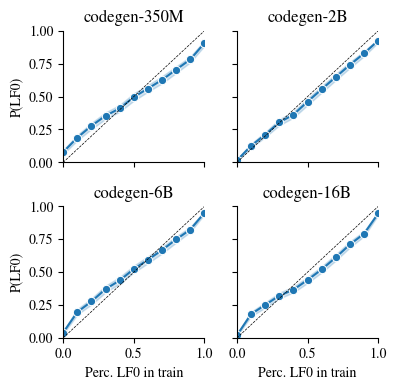

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt 
import pandas as pd
from colors import colors, markers 

plt.rcParams["font.family"] = "Nimbus Roman"

df = pd.DataFrame(data_for_df)


##  Normalized minimum probability
print("NORMALIZED MINIMUM PROBABILITY")
norm_df = df[df['type'] == "norm_min_lf0"]
small_df = norm_df[norm_df['model'] == "codegen-350M"]
medium_df = norm_df[norm_df['model'] == "codegen-2B"]
large_df = norm_df[norm_df['model'] == "codegen-6B"]
huge_df = norm_df[norm_df['model'] == "codegen-16B"]

fig, ax = plt.subplots(2,2, figsize=(4,4), sharex=True, sharey=True)

sns.lineplot(data = small_df, x="s1", y="value", ax=ax[0,0], marker = "o") # markers = markers, palette=colors, style='amb_type', hue="amb_type", legend=False)
ax[0,0].set_title("codegen-350M")
ax[0,0].set_ylim(0,1)
ax[0,0].set_xlim(0,1)
sns.lineplot(data = medium_df, x="s1", y="value", ax=ax[0,1], marker = "o") # markers = markers, palette=colors, style='amb_type', hue="amb_type", legend=False)
ax[0,1].set_title("codegen-2B")

sns.lineplot(data = large_df, x="s1", y="value", ax=ax[1,0],  marker = "o") #markers = markers, palette=colors, style='amb_type', hue="amb_type", legend=False)
ax[1,0].set_title("codegen-6B")
sns.lineplot(data = huge_df, x="s1", y="value", ax=ax[1,1],  marker = "o") # markers = markers, palette=colors, style='amb_type', hue="amb_type", legend=False)
ax[1,1].set_title("codegen-16B")


increasing_line_xs = np.linspace(0, 100)
increasing_line_ys = np.linspace(0, 100)

for i,j in [(0,0), (0,1), (1,0), (1,1)]:
    ax[i,j].plot(increasing_line_xs/100, increasing_line_ys/100, color="black", linestyle="--", linewidth=0.5)
    ax[i,j].set_ylabel("P(LF0)")
    ax[i,j].set_xlabel("Perc. LF0 in train")

sns.despine()


plt.tight_layout()
plt.savefig("/home/estengel/papers/ambiguous-parsing-2023/figures/mixed_prompt_forced.pdf")

SEQUENCE PROB. LF 0


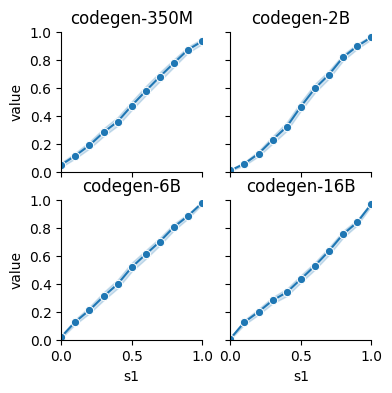

In [6]:

##  Normalized total probability
# print("SEQUENCE PROB. LF 0")
# prob_df = df[df['type'] == "norm_total_lf0"]
# small_df = prob_df[prob_df['model'] == "codegen-350M"]
# medium_df = prob_df[prob_df['model'] == "codegen-2B"]
# large_df = prob_df[prob_df['model'] == "codegen-6B"]
# huge_df = prob_df[prob_df['model'] == "codegen-16B"]

# fig, ax = plt.subplots(2,2, figsize=(4,4), sharex=True, sharey=True)

# sns.lineplot(data = small_df, x="s1", y="value", ax=ax[0,0],  marker = "o")
# ax[0,0].set_title("codegen-350M")
# ax[0,0].set_ylim(0,1)
# ax[0,0].set_xlim(0,1)
# sns.lineplot(data = medium_df, x="s1", y="value", ax=ax[0,1],  marker = "o")
# ax[0,1].set_title("codegen-2B")

# sns.lineplot(data = large_df, x="s1", y="value", ax=ax[1,0],  marker = "o")
# ax[1,0].set_title("codegen-6B")
# sns.lineplot(data = huge_df, x="s1", y="value", ax=ax[1,1],  marker = "o")
# ax[1,1].set_title("codegen-16B")

# sns.despine()
